In [160]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# 予測結果の精度確認（ROC曲線の描画）
from sklearn.metrics import roc_auc_score, roc_curve
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt

In [161]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset

## 訓練データの読み込み

In [208]:
# CSVファイル読み込み（訓練データ）
df_train = pd.read_csv('train.csv')
df_train.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [209]:
# 性別を変換する（訓練データ）
# gemder=pd.get_dummies(df_train.loc[:,['Gender']])
# df_train['Female']=gemder.loc[:,['Gender_Female']]
# df_train['Male']=gemder.loc[:,['Gender_Male']]
df_train.drop(columns=['Gender'],inplace=True)
df_train.drop(columns=['Age'],inplace=True)
df_train.head()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,disease
0,0.786886,0.150498,220.178691,13.467617,21.729246,0
1,1.003987,0.195625,221.218413,51.033462,64.752323,1
2,0.657140,0.081287,320.770533,12.625011,30.613180,0
3,0.906822,0.214173,369.278160,34.347597,54.510085,1
4,1.734959,0.197706,222.782025,20.572891,170.010177,0


In [210]:
df_train.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,disease
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,1.607337,0.606737,272.211316,41.978476,61.018120,0.444706
std,2.443585,1.569032,200.348515,145.927366,110.125390,0.497226
min,0.585961,0.034861,163.261838,3.924518,11.283497,0.000000
25%,0.781258,0.144889,213.991414,13.644658,21.239157,0.000000
50%,0.835591,0.194085,220.092503,16.638001,27.056026,0.000000
75%,1.196759,0.335447,229.455927,23.056081,56.461568,1.000000
max,23.017027,17.692164,2108.483728,1423.186473,814.439397,1.000000


# 評価データの読み込み

In [211]:
# CSVファイル読み込み（評価データ）
df_vat = pd.read_csv('test.csv')
df_vat.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,Male,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,Female,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


In [212]:
# 性別を変換する（検証データ）
# gemder=pd.get_dummies(df_vat.loc[:,['Gender']])
# df_vat['Female']=gemder.loc[:,['Gender_Female']]
# df_vat['Male']=gemder.loc[:,['Gender_Male']]
df_vat.drop(columns=['Gender'],inplace=True)
df_vat.drop(columns=['Age'],inplace=True)
df_vat.head()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT
0,0.801797,0.186800,214.448679,15.260516,19.496649
1,0.834857,0.116426,234.136816,10.509159,16.733312
2,0.791830,0.197940,216.039909,14.578304,20.695866
3,0.834003,0.175741,200.901130,12.820356,20.102517
4,0.690296,0.135503,208.705835,20.279018,25.096685


## データを加工する

In [213]:
def xConv(x_tmp):
    # T_Bilの変換
    bins = [0, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 100]
    x_tmp=comCutCnnect2(x_tmp, bins, 'T_Bil')

    # D_Bilの変換
    bins = [0, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 100]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'D_Bil' )
    
    # ALPの変換
    bins = [0, 200, 210, 220, 225, 230, 300, 350, 600 , 2500]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'ALP' )
    
    # ALT_GPTの変換
    bins = [0,  10, 12.5, 15, 17.5, 20, 22.5, 25, 50, 100, 1500]
    x_tmp=comCutCnnect2(x_tmp,  bins, 'ALT_GPT' )
    
    # AST_GOTの変換
    bins = [0, 20, 25, 30, 40, 50, 60, 1000]
    x_tmp=comCutCnnect2(x_tmp, bins, 'AST_GOT' )

    # TPの変換
#    bins = [0, 5.5, 6, 6.5, 7, 75, 1000]
#    x_tmp=comCutCnnect2(x_tmp,  bins, 'TP' )
    
    # Albの変換
#    bins = [0, 2.5, 2.8, 3.3, 3.8, 4.5, 1000]
#    x_tmp=comCutCnnect2(x_tmp,  bins, 'Alb' )

    # AG_ratioの変換
#    bins = [0, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1000]
#    x_tmp=comCutCnnect2(x_tmp,  bins, 'AG_ratio' )
    
    # Ageの変換の変換
#    bins = [0, 18, 25, 30, 35, 40, 50, 60, 70, 80 ,1000]
#    x_tmp=comCutCnnect(x_tmp,  bins, 'Age' )
        
    return x_tmp


def comCutCnnect(x_tmp, bins ,col ):   
    X_cut = pd.cut(x_tmp[col], bins=bins, labels=False)
    cutTemp = np.zeros((len(X_cut), len(bins) -1 ), dtype=int)
    cutTemp[np.arange(len(X_cut)), X_cut.T] = 1
    
    df=pd.DataFrame(cutTemp ,columns=[col + str(x) for x in range(cutTemp.shape[1])])
    
    # 列の削除
    x_tmp.drop(columns=[col], inplace=True, axis=1)
    # 列の追加
    x_tmp = pd.concat([x_tmp, df], axis=1)

    return x_tmp 

def comCutCnnect2(x_tmp, bins ,col ):   
    X_cut = pd.cut(x_tmp[col], bins=bins, labels=False)
    
    # 列の削除
    x_tmp.drop(columns=[col], inplace=True, axis=1)
    # 列の追加
    x_tmp = pd.concat([x_tmp, X_cut], axis=1)

    return x_tmp 

In [214]:
# 特徴量選択
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# 多項式・交互作用特徴量
from sklearn.preprocessing import PolynomialFeatures


#### 訓練データのデータ加工前処理

In [215]:
# 説明変数（訓練データ）
#x_tmp=xConv(df_train.loc[:,['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio', 'Female', 'Male']])
#x_tmp=xConv(df_train.loc[:,['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']])
#x_tmp=xConv(df_train.loc[:,['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT']])
x_tmp=df_train.loc[:,['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT']]

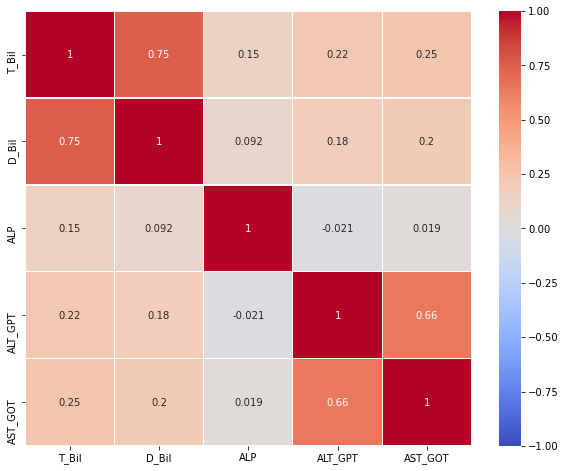

In [216]:
# seabornライブラリをsnsという省略名でインポート
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(x_tmp.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

In [217]:
print(x_tmp.head())

      T_Bil     D_Bil         ALP    ALT_GPT     AST_GOT
0  0.786886  0.150498  220.178691  13.467617   21.729246
1  1.003987  0.195625  221.218413  51.033462   64.752323
2  0.657140  0.081287  320.770533  12.625011   30.613180
3  0.906822  0.214173  369.278160  34.347597   54.510085
4  1.734959  0.197706  222.782025  20.572891  170.010177


In [218]:
print(x_tmp.shape)

(850, 5)


In [219]:
# 目的変数（訓練データ）
y_train = np.array(df_train.loc[:,['disease']])

# 組み込み法に使うモデルの指定
fs_model = LogisticRegression(penalty='l2', random_state=0)
# 閾値の指定
fs_threshold = "mean"
# 組み込み法モデルの初期化
selector = SelectFromModel(fs_model, threshold=fs_threshold)

# 特徴量生成
polynomial = PolynomialFeatures(degree=3, include_bias=False)
polynomial_arr = polynomial.fit_transform(np.array(x_tmp))
# polynomial_arrのデータフレーム化 （※カラムはshape[1]でpolynomial_arrの列数分だけ出力）
X_polynomial = pd.DataFrame(polynomial_arr, columns=["poly" + str(x_) for x_ in range(polynomial_arr.shape[1])])

# 特徴量選択の実行
selector.fit(X_polynomial, y_train)
mask = selector.get_support()

# 選択された特徴量だけのサンプル取得
X_polynomial_masked = X_polynomial.loc[:, mask]

x_train = np.array(X_polynomial_masked)




C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [220]:
X_polynomial.describe()

,poly0,poly1,poly2,poly3,poly4,poly5,poly6,poly7,poly8,poly9,...,poly45,poly46,poly47,poly48,poly49,poly50,poly51,poly52,poly53,poly54
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,...,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02
mean,1.607337,0.606737,272.211316,41.978476,61.018120,8.547614,3.859753,509.937606,145.753132,164.925774,...,1.049830e+08,3.826384e+06,7.625892e+06,5.225137e+06,3.013613e+06,3.913470e+06,2.701302e+07,1.262369e+07,7.463401e+06,8.680600e+06
std,2.443585,1.569032,200.348515,145.927366,110.125390,39.679509,24.107842,1705.310586,934.508134,586.179870,...,7.621025e+08,1.315924e+07,3.485339e+07,4.126780e+07,1.906203e+07,1.695947e+07,2.451896e+08,1.047165e+08,5.497577e+07,5.033966e+07
min,0.585961,0.034861,163.261838,3.924518,11.283497,0.343350,0.023541,123.727799,2.677546,7.888472,...,4.351651e+06,2.028397e+05,4.722679e+05,3.501515e+03,1.848636e+04,2.931812e+04,6.044482e+01,5.711652e+02,9.058295e+02,1.436584e+03
25%,0.781258,0.144889,213.991414,13.644658,21.239157,0.610365,0.117172,169.889105,11.070056,16.990119,...,9.799164e+06,6.460827e+05,9.766780e+05,4.162272e+04,6.565971e+04,9.657725e+04,2.540318e+03,4.295678e+03,6.466057e+03,9.581023e+03
50%,0.835591,0.194085,220.092503,16.638001,27.056026,0.698213,0.161587,187.719480,14.424961,24.120383,...,1.066144e+07,8.450279e+05,1.387040e+06,6.552227e+04,1.240031e+05,1.735209e+05,4.605782e+03,9.533538e+03,1.419220e+04,1.980578e+04
75%,1.196759,0.335447,229.455927,23.056081,56.461568,1.432468,0.414427,354.161167,31.776001,57.163270,...,1.208086e+07,1.617172e+06,3.380981e+06,1.506461e+05,3.192441e+05,7.806760e+05,1.225627e+04,2.579833e+04,6.554528e+04,1.799961e+05
max,23.017027,17.692164,2108.483728,1423.186473,814.439397,529.783523,407.166194,42811.342137,12178.050907,5348.745296,...,9.373694e+09,1.808344e+08,7.544651e+08,4.509293e+08,1.969584e+08,1.579172e+08,2.882607e+09,1.232256e+09,6.162836e+08,5.402270e+08


In [221]:
X_polynomial_masked.describe()

,poly14,poly29,poly31,poly34,poly39,poly41,poly46,poly48,poly51,poly53,poly54
count,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02
mean,1.141913e+05,2.972964e+05,4.733072e+04,5.297061e+04,1.200723e+05,2.016042e+04,3.826384e+06,5.225137e+06,2.701302e+07,7.463401e+06,8.680600e+06
std,3.889466e+05,2.852566e+06,1.693150e+05,3.033284e+05,1.455277e+06,8.507927e+04,1.315924e+07,4.126780e+07,2.451896e+08,5.497577e+07,5.033966e+07
min,2.665443e+04,2.381465e+04,1.735434e+03,9.457286e+01,1.366136e+03,1.347141e+02,2.028397e+05,3.501515e+03,6.044482e+01,9.058295e+02,1.436584e+03
25%,4.579233e+04,3.630463e+04,3.644283e+03,3.622803e+02,7.184365e+03,7.957307e+02,6.460827e+05,4.162272e+04,2.540318e+03,6.466057e+03,9.581023e+03
50%,4.844071e+04,4.126533e+04,6.418378e+03,6.737181e+02,9.694323e+03,1.303636e+03,8.450279e+05,6.552227e+04,4.605782e+03,1.419220e+04,1.980578e+04
75%,5.265002e+04,9.185716e+04,1.833742e+04,3.461010e+03,2.867047e+04,4.610219e+03,1.617172e+06,1.506461e+05,1.225627e+04,6.554528e+04,1.799961e+05
max,4.445704e+06,7.967825e+07,2.693340e+06,3.209399e+06,4.149166e+07,1.402530e+06,1.808344e+08,4.509293e+08,2.882607e+09,6.162836e+08,5.402270e+08


In [222]:
X_polynomial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 55 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   poly0   850 non-null    float64
 1   poly1   850 non-null    float64
 2   poly2   850 non-null    float64
 3   poly3   850 non-null    float64
 4   poly4   850 non-null    float64
 5   poly5   850 non-null    float64
 6   poly6   850 non-null    float64
 7   poly7   850 non-null    float64
 8   poly8   850 non-null    float64
 9   poly9   850 non-null    float64
 10  poly10  850 non-null    float64
 11  poly11  850 non-null    float64
 12  poly12  850 non-null    float64
 13  poly13  850 non-null    float64
 14  poly14  850 non-null    float64
 15  poly15  850 non-null    float64
 16  poly16  850 non-null    float64
 17  poly17  850 non-null    float64
 18  poly18  850 non-null    float64
 19  poly19  850 non-null    float64
 20  poly20  850 non-null    float64
 21  poly21  850 non-null    float64
 22  po

In [223]:
X_polynomial_masked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   poly14  850 non-null    float64
 1   poly29  850 non-null    float64
 2   poly31  850 non-null    float64
 3   poly34  850 non-null    float64
 4   poly39  850 non-null    float64
 5   poly41  850 non-null    float64
 6   poly46  850 non-null    float64
 7   poly48  850 non-null    float64
 8   poly51  850 non-null    float64
 9   poly53  850 non-null    float64
 10  poly54  850 non-null    float64
dtypes: float64(11)
memory usage: 73.2 KB


#### 評価データのデータ加工前処理

In [224]:
# 説明変数（評価データ）
#x_tmp=xConv(df_vat)
x_tmp=df_vat

In [225]:

# 組み込み法に使うモデルの指定
fs_model = LogisticRegression(penalty='l2', random_state=0)
# 閾値の指定
fs_threshold = "mean"
# 組み込み法モデルの初期化
selector = SelectFromModel(fs_model, threshold=fs_threshold)

# 特徴量生成
polynomial = PolynomialFeatures(degree=3, include_bias=False)
polynomial_arr = polynomial.fit_transform(x_tmp)
# polynomial_arrのデータフレーム化 （※カラムはshape[1]でpolynomial_arrの列数分だけ出力）
X_polynomial = pd.DataFrame(polynomial_arr, columns=["poly" + str(x) for x in range(polynomial_arr.shape[1])])

# 選択された特徴量だけのサンプル取得
X_polynomial_masked = X_polynomial.loc[:, mask]

x_vat = np.array(X_polynomial_masked)


In [226]:
# yの変換
#y = np.zeros((len(y_train), 1 + y_train.max()), dtype=int)
#y[np.arange(len(y_train)), y_train.T] = 1
#y_train = y
# 分割
X_train,X_test,Y_train,Y_test=train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

In [227]:
# 標準化
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sc = StandardScaler() 
#norm = MinMaxScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
X_vat=sc.transform(x_vat)

In [228]:
# numpy の値を torch の値に変換する
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()
X_vat  = torch.from_numpy(X_vat).float()

In [229]:
# 行数、列数の確認
in_size=X_train.shape[1]
print(X_train.shape)
print(X_test.shape)


torch.Size([637, 11])
torch.Size([213, 11])


In [230]:
out_size=Y_train.shape[1]
Y_train.shape

torch.Size([637, 1])

In [231]:
print(X_vat.shape)


torch.Size([350, 11])


In [232]:
# x と y の値をひとつの変数に格納する
train = TensorDataset(X_train ,Y_train)

In [233]:
# batch_size ：学習する時にまとめるデータ数
# shuffle    : データをランダムに並び替える場合はTrue
#train_loader = DataLoader(train ,batch_size=30, shuffle=True, num_workers=2)
train_loader = DataLoader(train ,batch_size=30, shuffle=True)

In [234]:
node1=60
node2=100
node3=60
node4=20


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net ,self).__init__()
        #   中間層のノード数は、精度向上やパフォーマンス向上を狙って調整する
        self.fc1 = nn.Linear(in_size , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
#        self.fc2 = nn.Linear(node1 , node2)           # nn.Linear (中間層ノード数 , 中間層ノード数)
#        self.fc3 = nn.Linear(node2 , node3)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc4 = nn.Linear(node1 , node4)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc5 = nn.Linear(node4,  out_size)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
#        x = torch.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
#        x = F.sigmoid(self.fc2(x))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        y = torch.sigmoid (self.fc1(x))               # 入力のノードを中間層（１階層目）に渡して結果を得る
#        y = torch.sigmoid(self.fc2(y))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
#        y = torch.sigmoid(self.fc3(y))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        y = torch.sigmoid(self.fc4(y))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        y = torch.sigmoid(self.fc5(y))            # 中間層（２階層目）の結果を出力層に渡す
        # dim　:求めたい確率の値　今回は１になる確率
        #return F.log_softmax(y , dim=0)
        return y

In [235]:
# モデルの定義
model = Net()
# 損失の定義 (平均二乗誤差)
#criterion = nn.MSELoss()
# 損失の定義 (平均二乗誤差)
criterion = nn.BCELoss()
# 損失の定義 (交差エントロピー誤差関数)
#criterion = nn.CrossEntropyLoss()

In [236]:
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
## model.parameters  調整する値
## lr(learning rate) ：学習率　どれぐらいの幅でパラメータを更新していくのか
optimizer = optim.Adam(model.parameters() , lr=0.01)
#optimizer = optim.SGD(model.parameters() , lr=0.01)

In [237]:
loss_list = []
loss_temp = 0
logdisp=10
# トレーニングの回数分ループする。
for epoch in range(200):
    # 損失を初期化　
    total_loss = 0
    
    # データの件数分ループする。（x_train , y_train　に１レコードずつ格納される）
    for x_train , y_train in train_loader:
        # Variable ：　torch,autograd.Variable  ：テンソルをwrapして計算操作を記録する
        x_train ,y_train = Variable(x_train) ,Variable(y_train)
        # 出力を計算する 
        output = model(x_train)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss = criterion(output ,y_train)
        # パラメータの勾配を初期化する
        optimizer.zero_grad()
        # ロスを伝播する
        loss.backward()
        # パラメータを更新する
        optimizer.step()
        # トータルロスを格納
        total_loss += loss.item()
        loss_temp += loss

    # 10回毎に回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_list.append(loss.item()/(logdisp*len(train_loader)))
        print(f'Epoch {epoch+1} Loss {loss.item()/(logdisp*len(train_loader))} -- {loss_temp}')
        loss_temp = 0

Epoch 10 Loss 0.001888787340034138 -- 122.21227264404297
Epoch 20 Loss 0.0008767948231913826 -- 104.1393814086914
Epoch 30 Loss 0.0028961980884725396 -- 96.21504974365234
Epoch 40 Loss 0.0011830543929880317 -- 96.72388458251953
Epoch 50 Loss 0.0012381809678944674 -- 94.54415130615234
Epoch 60 Loss 0.0022591139782558787 -- 93.95427703857422
Epoch 70 Loss 0.0018347790295427497 -- 94.18455505371094
Epoch 80 Loss 0.0035422352227297694 -- 92.7039794921875
Epoch 90 Loss 0.002726912498474121 -- 93.84605407714844
Epoch 100 Loss 0.002161130038174716 -- 91.66485595703125
Epoch 110 Loss 0.0020954864946278657 -- 92.84112548828125
Epoch 120 Loss 0.0022217768159779635 -- 92.8696517944336
Epoch 130 Loss 0.004945093393325805 -- 92.56033325195312
Epoch 140 Loss 0.001725023172118447 -- 90.87468719482422
Epoch 150 Loss 0.0016063916412266818 -- 91.01419067382812
Epoch 160 Loss 0.002632899446920915 -- 92.22566223144531
Epoch 170 Loss 0.0005175900052894246 -- 90.11426544189453
Epoch 180 Loss 0.0010968704792

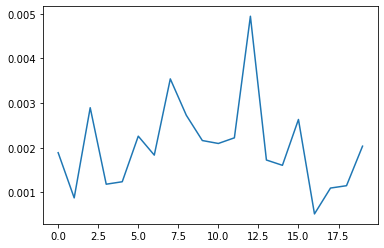

In [238]:
# ロスのプロット
plt.plot(loss_list)

## 誤差の確認

In [239]:
#print(Y_test)

In [240]:
# 学習を行わないモードに変更
model.eval()

# テストデータ
x ,y = Variable(X_test) ,Variable(Y_test)
###   # テストデータｘに対する結果　（値の大きい方を取得する）
###   y_hat = torch.max(model(x).data ,1)[1]
###   y_true = torch.max(y ,1)[1]
###   # テストｘの結果とｙの比較　（結果が一致したら加算して、不一致は加算しない。その結果をデータ数で割る）
###   accuracy = np.sum(y_true.data.numpy() == y_hat.numpy()) /len(y_true.data.numpy())
###   print(accuracy)
###   print(y_hat.numpy())
###   print(y_true.data.numpy())

y_hat=model(x).data
y_true=Y_test.numpy()
accuracy = np.sum(Y_test.numpy() == y_hat.round().numpy()) /len(Y_test.numpy())
print(accuracy)


0.8356807511737089


## ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）

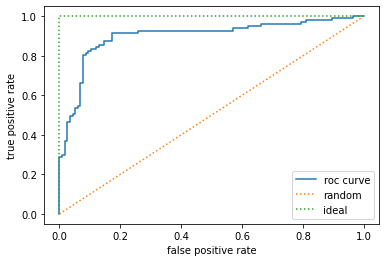

[1.9856248  0.9856248  0.9856242  0.971476   0.96923244 0.9669553
 0.904736   0.8901883  0.8892793  0.86759114 0.86315453 0.81406075
 0.81219137 0.7997491  0.79537994 0.7609208  0.72465396 0.72316295
 0.708777   0.6113178  0.60650563 0.38751784 0.3863057  0.38518465
 0.3849651  0.3811725  0.36241663 0.36072224 0.33057448 0.3299694
 0.32432225 0.31012154 0.28835386 0.2836838  0.24502622 0.20528482
 0.15918915 0.14645194 0.09446591 0.09411073 0.09098735 0.09006382
 0.0859247  0.08525069 0.07699458 0.07653844 0.07239526 0.0718172
 0.06479034 0.06423962 0.05314229 0.0485811  0.03303175]


In [241]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_hat)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [242]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_true, y_score=y_hat)
print("AUC:", auc_score)

AUC: 0.90037326697476


#  予測する

In [243]:
y_predict = model(X_vat).data
print(y_predict)
y_predict = y_predict.round().numpy()
df_out = pd.DataFrame(np.array(y_predict ,dtype=np.int64), columns=['val'])

df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False)


tensor([[0.0914],
        [0.0595],
        [0.0915],
        [0.0836],
        [0.1203],
        [0.0839],
        [0.9856],
        [0.6115],
        [0.1314],
        [0.0829],
        [0.1271],
        [0.1765],
        [0.1128],
        [0.9856],
        [0.0914],
        [0.0486],
        [0.8260],
        [0.0835],
        [0.0892],
        [0.0765],
        [0.5509],
        [0.0934],
        [0.0583],
        [0.5770],
        [0.1193],
        [0.0832],
        [0.1171],
        [0.9856],
        [0.1202],
        [0.9856],
        [0.2691],
        [0.9856],
        [0.0784],
        [0.3664],
        [0.9815],
        [0.9856],
        [0.0932],
        [0.1264],
        [0.0830],
        [0.9856],
        [0.6157],
        [0.5749],
        [0.4787],
        [0.0850],
        [0.3389],
        [0.4045],
        [0.0944],
        [0.8855],
        [0.0483],
        [0.1191],
        [0.2604],
        [0.8840],
        [0.9856],
        [0.1776],
        [0.3198],
        [0

# モデルの保存

In [244]:
#model_path = 'model.pth'
#torch.save(model.to('cpu').state_dict(), model_path)